In [1]:
# importing the libraries
import os
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

There are 279 patients having there own unique id

In [16]:
base_path = "dataset/IDC_regular_ps50_idx5/"
folder = os.listdir(base_path)
print(len(folder))

140


In [17]:
from glob import glob
imagePatches = glob('dataset/IDC_regular_ps50_idx5/**/*.png', recursive=True)
print(len(imagePatches)) # total no. of images

155123


In [18]:
for i in range(10):
    print(imagePatches[i])

dataset/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1001_class0.png
dataset/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1051_class0.png
dataset/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1101_class0.png
dataset/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1151_class0.png
dataset/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1201_class0.png
dataset/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1251_class0.png
dataset/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1301_class0.png
dataset/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1351_class0.png
dataset/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1501_class0.png
dataset/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1551_class0.png


In [19]:
import fnmatch
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)

y = []
for img in imagePatches:
    if img in classZero:
        y.append(0)
    elif img in classOne:
        y.append(1)
        

In [20]:
images_df = pd.DataFrame()
images_df["images"] = imagePatches
images_df["labels"] = y
images_df.head()

,images,labels
0,dataset/IDC_regular_ps50_idx5\10253\0\10253_id...,0
1,dataset/IDC_regular_ps50_idx5\10253\0\10253_id...,0
2,dataset/IDC_regular_ps50_idx5\10253\0\10253_id...,0
3,dataset/IDC_regular_ps50_idx5\10253\0\10253_id...,0
4,dataset/IDC_regular_ps50_idx5\10253\0\10253_id...,0


In [21]:
images_df.to_csv('dataset/dataset.csv',index = False) # forming the dataset

In [22]:
images_df.shape

(155123, 2)

In [23]:
images_df.groupby("labels")["labels"].count()

labels
0    115619
1     39504
Name: labels, dtype: int64

In [ ]:
images_df = pd.read_csv()

In [24]:
# spliting the dataset into train test and validation parts
train, test = train_test_split(images_df, stratify=images_df.labels, test_size=0.33)
print(len(train),len(test))

103932 51191


In [25]:
train

,images,labels
123354,dataset/IDC_regular_ps50_idx5\9227\0\9227_idx5...,0
128527,dataset/IDC_regular_ps50_idx5\9256\0\9256_idx5...,0
123503,dataset/IDC_regular_ps50_idx5\9227\0\9227_idx5...,0
44116,dataset/IDC_regular_ps50_idx5\10303\1\10303_id...,1
120727,dataset/IDC_regular_ps50_idx5\9225\0\9225_idx5...,0
...,...,...
145190,dataset/IDC_regular_ps50_idx5\9323\0\9323_idx5...,0
152186,dataset/IDC_regular_ps50_idx5\9381\0\9381_idx5...,0
42839,dataset/IDC_regular_ps50_idx5\10302\1\10302_id...,1
19111,dataset/IDC_regular_ps50_idx5\10276\0\10276_id...,0


In [26]:
# saving the data in .csv format in different directories
train.to_csv('dataset/train/train.csv',index=False)
test.to_csv('dataset/test/test.csv',index=False)

In [37]:
# Reading the dataset
train = pd.read_csv('dataset/train/train.csv')
test = pd.read_csv('dataset/test/test.csv')

In [2]:
#importing the libraries of pytorch
import torch 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [39]:
class Transformed_dataset(Dataset):
    def __init__(self, df_data,transform=None):
        super().__init__()
        self.df = df_data.values
        
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path,label = self.df[index]
        
        image = cv2.imread(img_path)
        image = cv2.resize(image, (50,50))
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [40]:
# Data preprocessing

trans_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.RandomHorizontalFlip(), 
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

trans_valid = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

dataset_train = Transformed_dataset(df_data=train, transform=trans_train)
dataset_valid = Transformed_dataset(df_data=test,transform=trans_valid)

In [41]:
loader_train = DataLoader(dataset = dataset_train, batch_size=32, shuffle=True, num_workers=0)
loader_valid = DataLoader(dataset = dataset_valid, batch_size=32, shuffle=False, num_workers=0)

In [35]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

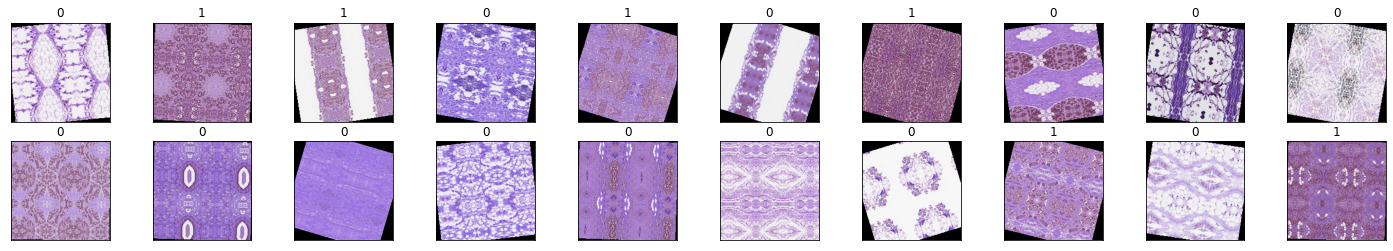

In [40]:
# obtain one batch of training images
dataiter = iter(loader_train)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(labels[idx].numpy())

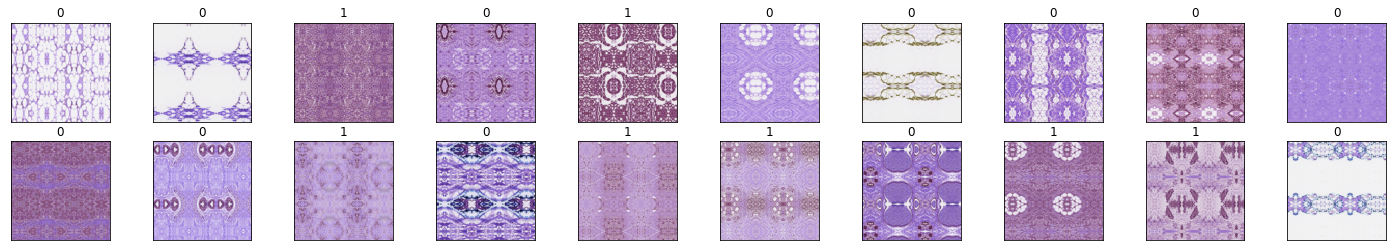

In [42]:
# obtain one batch of testing images
dataiter = iter(loader_valid)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(labels[idx].numpy())

In [9]:
# making the model architecture
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# definning the model architecture
class SimpleCNN(nn.Module):
    def __init__(self):

        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(8)
        self.fc = nn.Linear(256 * 1 * 1, 2) # !!!
        
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.avg(x)
        #print(x.shape)
        x = x.view(-1, 256 * 1 * 1)
        x = self.fc(x)
        return x

In [11]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
model = SimpleCNN()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
if train_on_gpu:
    model.cuda()

print(model)

CUDA is available!  Training on GPU ...
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [58]:

# Hyper parameters
num_epochs = 10
num_classes = 2
learning_rate = 0.01

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

In [48]:
 torch.cuda.empty_cache()

In [59]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [60]:
t = torch.cuda.get_device_properties(0).total_memory
c = torch.cuda.memory_cached(0)
a = torch.cuda.memory_allocated(0)
f = c-a  # free inside cache
print(t,c,a,f)

4294967296 157286400 5022208 152264192


In [61]:
# Train the model
total_step = len(loader_train)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(loader_train):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/10], Step [100/3248], Loss: 0.2250
Epoch [1/10], Step [200/3248], Loss: 0.2755
Epoch [1/10], Step [300/3248], Loss: 0.4902
Epoch [1/10], Step [400/3248], Loss: 0.4917
Epoch [1/10], Step [500/3248], Loss: 0.3682
Epoch [1/10], Step [600/3248], Loss: 0.4487
Epoch [1/10], Step [700/3248], Loss: 0.3578
Epoch [1/10], Step [800/3248], Loss: 0.3319
Epoch [1/10], Step [900/3248], Loss: 0.5446
Epoch [1/10], Step [1000/3248], Loss: 0.5154
Epoch [1/10], Step [1100/3248], Loss: 0.2410
Epoch [1/10], Step [1200/3248], Loss: 0.3903
Epoch [1/10], Step [1300/3248], Loss: 0.2875
Epoch [1/10], Step [1400/3248], Loss: 0.3314
Epoch [1/10], Step [1500/3248], Loss: 0.3575
Epoch [1/10], Step [1600/3248], Loss: 0.6452
Epoch [1/10], Step [1700/3248], Loss: 0.2961
Epoch [1/10], Step [1800/3248], Loss: 0.4699
Epoch [1/10], Step [1900/3248], Loss: 0.4180
Epoch [1/10], Step [2000/3248], Loss: 0.2104
Epoch [1/10], Step [2100/3248], Loss: 0.3890
Epoch [1/10], Step [2200/3248], Loss: 0.3095
Epoch [1/10], Step 

Epoch [6/10], Step [2500/3248], Loss: 0.2283
Epoch [6/10], Step [2600/3248], Loss: 0.3241
Epoch [6/10], Step [2700/3248], Loss: 0.2438
Epoch [6/10], Step [2800/3248], Loss: 0.1165
Epoch [6/10], Step [2900/3248], Loss: 0.2666
Epoch [6/10], Step [3000/3248], Loss: 0.2649
Epoch [6/10], Step [3100/3248], Loss: 0.2315
Epoch [6/10], Step [3200/3248], Loss: 0.2536
Epoch [7/10], Step [100/3248], Loss: 0.2977
Epoch [7/10], Step [200/3248], Loss: 0.2505
Epoch [7/10], Step [300/3248], Loss: 0.3555
Epoch [7/10], Step [400/3248], Loss: 0.1962
Epoch [7/10], Step [500/3248], Loss: 0.2273
Epoch [7/10], Step [600/3248], Loss: 0.3040
Epoch [7/10], Step [700/3248], Loss: 0.3381
Epoch [7/10], Step [800/3248], Loss: 0.1603
Epoch [7/10], Step [900/3248], Loss: 0.1278
Epoch [7/10], Step [1000/3248], Loss: 0.1230
Epoch [7/10], Step [1100/3248], Loss: 0.2550
Epoch [7/10], Step [1200/3248], Loss: 0.4169
Epoch [7/10], Step [1300/3248], Loss: 0.3446
Epoch [7/10], Step [1400/3248], Loss: 0.3324
Epoch [7/10], Step 

In [62]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
                 
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the test images: 89.39657361645602 %


In [63]:
print(confusion_matrix)

tensor([[34947.,  3208.],
        [ 2220., 10816.]])


# Testing on unseen data

In [3]:
# TESTING
from PIL import Image  
from matplotlib.pyplot import imshow

In [4]:
trans_valid = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

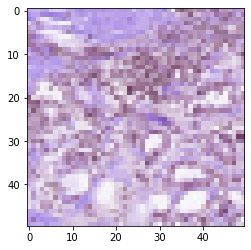

In [5]:
img_path = r"D:\internship\brast cancer\dataset\IDC_regular_ps50_idx5\12867\1\12867_idx5_x951_y1251_class1.png"

image = cv2.imread(img_path)
image = cv2.resize(image, (50,50))
imshow(np.asarray(image))

In [6]:
image = trans_valid(image)
print(type(image),image.shape)

<class 'torch.Tensor'> torch.Size([3, 178, 178])


In [12]:
model.load_state_dict(torch.load('model.ckpt'))
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

In [13]:
image = image.cuda()
output = model(image.unsqueeze(0))
_, predict = torch.max(output.data, 1)
predict = predict.cpu()
print(predict.numpy().item())

1


Since the output of the model is for the image 12867_idx5_x951_y1251_class1 , Breast Cancer has been detected which is also true according to the label of the image.